In [1]:
import pandas as pd
import json
import re
import unicodedata
import numpy as np
data = pd.read_csv("./quotations.csv", on_bad_lines='skip',sep=";")

# Filter to just “Fensterreinigung” and drop rows missing requirements_textual
data = data.loc[
     data['requirements_textual'].notna()
    & data['price'].notna()
]


#    (booking['product_name'] == "Fensterreinigung")
#    & booking['quotation_info_request'].isna()


In [2]:
#Nur Spezialreinigungsanfragen

data.keys()

#Absolute und relative Häufigkeit von Reinigungsarten
countProduct = (lambda x: [ sum((data["product_name"]==x)) \
                           ,sum((data["product_name"]==x)) / len(data["product_name"]) \
                            ,x ])

products = sorted(list(map(countProduct,data["product_name"].unique())),reverse=True)
products = pd.DataFrame(products, columns=["freq","relFreq","name"])
#products = products.sort_values(by="freq", ascending=False)
products

for i in products.index:
    if i>0:
        products.at[i,"cumRelFreq"]=products.at[i-1,"cumRelFreq"] + products.at[i,"relFreq"]
    else:
        products.at[i,"cumRelFreq"]=products.at[i,"relFreq"]

products[["cumRelFreq","relFreq"]] = round(products[["cumRelFreq","relFreq"]], 2)

shortened = products.head(3)
othersFreq =  sum(products["freq"]) - sum(shortened["freq"])  
othersRelFreq = round( othersFreq / sum(products["freq"])  ,  2)
othersCumRelFreq = 1
shortened.loc[len(shortened)] = [othersFreq,othersRelFreq,"Sonstige",othersCumRelFreq]
shortened

#shortened["freq"]
#pd.concat([[0,0,0,0],shortened])
#help(pd.concat)
#help(pd.DataFrame.sort_values)

/tmp/ipykernel_3260376/2893397658.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened.loc[len(shortened)] = [othersFreq,othersRelFreq,"Sonstige",othersCumRelFreq]


freq  relFreq               name  cumRelFreq
0  5169     0.41    Umzugsreinigung        0.41
1  2448     0.19  Intensivreinigung        0.60
2  2124     0.17   Fensterreinigung        0.77
3  2940     0.23           Sonstige        1.00

In [3]:
trainSampleSize = round(len(data.loc[data["product_name"]=="Umzugsreinigung"])*0.7)
umzugTrainingData = data.loc[data["product_name"]=="Umzugsreinigung"].sample(n=trainSampleSize, random_state=43).reset_index(drop=True)
umzugTrainingData.keys()
keys = ['comment_price', 'comment_important','comment_other']
umzugTrainingData = umzugTrainingData[keys]

#für jeden Key die nicht leeren Felder zählen
(lambda x: umzugTrainingData[x].notna())([*keys]).apply(sum)



comment_price        3618
comment_important    3078
comment_other          88
dtype: int64

In [128]:
#explore comment_price
comment_price = umzugTrainingData.loc[umzugTrainingData["comment_price"].notna(),"comment_price"]

#textOutlier = comment_price.apply(lambda x: x[0:29])!="Steckbrief - das Wichtigste z"

words = list(map(nltk.word_tokenize, comment_price))

#allWords = [w for sublist in words for w in sublist]
words = np.concatenate(words).tolist()
words = [w for w in words if len(w)>1]

#normalization
words = [w.lower() for w in words] #lowercase



#words
uniqWords = pd.Series(words).value_counts()
uniqWords = pd.DataFrame(uniqWords)
len(uniqWords)


3419

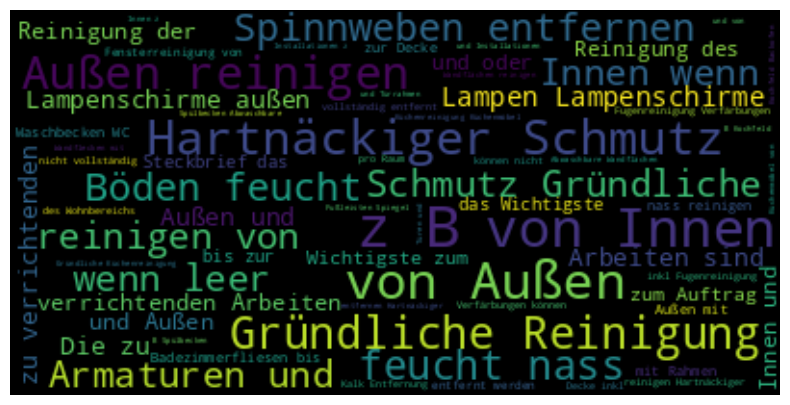

In [170]:
#Wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

combinedText = " ".join(comment_price.astype(str))


wordcloud = WordCloud(max_font_size=30,stopwords=[" ","z.B.", "z.B"]).generate(combinedText)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
#Split into blocks

def printSpaced(txt):
    """prints a seperator between each item"""
    for t in txt:
        print(t)
        print('---------------------\n')

def classifyLine(line):
    if line[0:3]=='\t◦\t':
        return("item")
    #elif line[0:1]=='\r':
    #    return("empty")
    elif (len(line) <= 1):
        return("empty")
    else:
        return("title")


i=0
text=comment_price[i]

blocks = text.split('\n\r\n')

#printSpaced(lines)
#list(map(classifyLine,lines))
#text
#lines

#classifyLine(lines[3])
#lines[3]



In [32]:
def classifyBlock(block):
    lines=block.split('\n')
    print(type(lines))
    if type(lines)=="str":
        return('singleLine')
classifyBlock(blocks[0])        

<class 'list'>


In [28]:
i=4


def validateBlock(block):
    lines=block.split('\n')
    printSpaced(lines)
    if len(lines) <= 1:
        return('empty')
    if type(lines)=="str":
        return('singleLine')
        
    if classifyLine(lines[0])!="title":
        raise Exception("block has no title")
        
    
    for l in lines[1:]:
        #print(classifyLine(l))
        if classifyLine(l)!="item" or classifyLine(l)!="empty":
            #print(l)
            raise Exception(f"item {l} not recognized")




lines = blocks[i].split('\n')
#print(blocks[i])

for b in blocks:
    classifyBlock(b)


#blocks[2]
#printSpaced(lines)

NameError: name 'classifyBlock' is not defined

In [41]:
#Tokenizing
import nltk

text=comment_price[0]
#text.replace("\n"," ")
#text
nltk.download("punkt_tab")

sentences = nltk.sent_tokenize(text)
#print(sentences[1])
sentences[1]





[nltk_data] Downloading package punkt_tab to /home/anton/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'Spülbecken)\r\n\t◦\tAbwaschbare Wandflächen reinigen\r\n\t◦\tSpinnweben entfernen\r\n\t◦\tHartnäckiger Schmutz\r\n\r\n\r\nFENSTERREINIGUNG\r\nDie zu verrichtenden Arbeiten sind:\r\n\t◦\tFensterreinigung von Innen und Außen mit Rahmen\r\n\t◦\tReinigung der Außen- und Innenseite des Glases\r\n\t◦\tReinigung der Fensterrahmen, Griffe und Beschläge\r\n\r\n\r\n\r\n\r\nOptional dazu buchbar (Kontaktieren Sie uns bei Interesse bevor Sie das Angebot annehmen):\r\n\t\r\n\t◦\tBehandlung von Wandflecken mit Wandradierer 30 € pro Raum\r\n\t◦\tPolstermöbel shampoonieren und/oder mit Geruchsvernichter behandeln\r\n\t◦\tReinigung von Balkon oder Terrasse\r\n\t◦\tAbnahmegarantie\r\n\t◦\tEntrümpelung\r\n\t◦\tRasenmähen und/oder Hecke schneiden'

In [62]:
#stop words
words = nltk.word_tokenize(text)
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('german')
#print(len(pd.unique(words)))

cleanWords = [word for word in words if word not in stop_words]
cleanWords

[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Steckbrief',
 '-',
 'Wichtigste',
 'Auftrag',
 ':',
 'Umzugsreinigung',
 '57m2',
 'leere',
 'Wohnung',
 'Möbel',
 ',',
 'inclusive',
 'Küche',
 '(',
 'Front',
 ')',
 ',',
 'Fenster',
 'Die',
 'verrichtenden',
 'Arbeiten',
 ':',
 'Gründliche',
 'Reinigung',
 'Bads',
 '/',
 'Sanitärräume',
 '◦',
 'Badewanne/Dusche',
 '◦',
 'Badezimmerfliesen',
 'Decke',
 '◦',
 'Waschbecken',
 '◦',
 'WC',
 '(',
 'innen',
 'außen',
 ')',
 '◦',
 'Armaturen',
 '◦',
 'Duschkabine',
 '/',
 'Duschglas',
 '/',
 'Badewannenglas',
 '◦',
 'Böden',
 'saugen',
 '◦',
 'Böden',
 'feucht',
 'wischen',
 '◦',
 'Hartnäckiger',
 'Schmutz',
 'Gründliche',
 'Reinigung',
 'restlichen',
 'Räume',
 '◦',
 'Böden',
 'saugen',
 '◦',
 'Böden',
 'feucht',
 'wischen',
 ',',
 'staubbindend',
 ',',
 'mehrfach',
 '◦',
 'Heizkörper',
 '◦',
 'Fensterbänke',
 '◦',
 'Türen',
 'Türrahmen',
 '◦',
 'Fußleisten',
 '◦',
 'Lichtschalter',
 '◦',
 'Steckdosen',
 'Küchenreinigung',
 '◦',
 'Küchenmöbel',
 'Außen',
 'reinigen',
 '(',
 'Innen',
 'leer

In [56]:
print(*cleanWords)

Steckbrief - Wichtigste Auftrag : Umzugsreinigung 57m2 leere Wohnung Möbel , inclusive Küche ( Front ) , Fenster Die verrichtenden Arbeiten : Gründliche Reinigung Bads / Sanitärräume ◦ Badewanne/Dusche ◦ Badezimmerfliesen Decke ◦ Waschbecken ◦ WC ( innen außen ) ◦ Armaturen ◦ Duschkabine / Duschglas / Badewannenglas ◦ Böden saugen ◦ Böden feucht wischen ◦ Hartnäckiger Schmutz Gründliche Reinigung restlichen Räume ◦ Böden saugen ◦ Böden feucht wischen , staubbindend , mehrfach ◦ Heizkörper ◦ Fensterbänke ◦ Türen Türrahmen ◦ Fußleisten ◦ Lichtschalter ◦ Steckdosen Küchenreinigung ◦ Küchenmöbel Außen reinigen ( Innen leer ) ◦ Armaturen Installationen ( z.B . Spülbecken ) ◦ Abwaschbare Wandflächen reinigen ◦ Spinnweben entfernen ◦ Hartnäckiger Schmutz FENSTERREINIGUNG Die verrichtenden Arbeiten : ◦ Fensterreinigung Innen Außen Rahmen ◦ Reinigung Außen- Innenseite Glases ◦ Reinigung Fensterrahmen , Griffe Beschläge Optional buchbar ( Kontaktieren Sie Interesse bevor Sie Angebot annehmen ) :